Libs

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

Functions

In [15]:
def get_yf_price(ticker, yf_data):

    try:
        # Handle case where yf_data might not have MultiIndex if only 1 ticker is downloaded
        if len(yf_data.columns.levels) > 1:
             return yf_data[ticker]['Close'].iloc[0]
        else:
             return yf_data['Close'].iloc[0]
    except KeyError:
        print(f"Ticker {ticker} not found in yfinance data.")
        return float('nan')

In [16]:
def print_wallet_balance(wallet_balance):

    # Get values
    wallet_return = sum(wallet_balance['return'] * wallet_balance['value_percent'])
    actual_price = sum(wallet_balance['total_value']) * (1 + wallet_return)
    return_value = sum(wallet_balance['total_value']) * wallet_return

    # Display data
    print('-'*40)
    print ('International Wallet Investment in ETFs')
    print('-'*40)
    print(f'Amount:.............. $ {sum(wallet_balance["total_value"]):.4f}')
    print(f'Actual Value:........ $ {actual_price:.4f}')
    print(f'Valorization:........ $ {return_value:.4f}')
    print(f'Wallet Performance:.. {wallet_return * 100:.4f} %')
    print('-'*40)

    for t in wallet_balance.index:

        print(f'{wallet_balance.loc[t, "ticker"]}')
        print(f'Value:............... $ {
                                        wallet_balance.loc[t, "total_value"] * (1 + wallet_balance.loc[t, "return"]):.4f
                                        } ({
                                            wallet_balance.loc[t, "return"] * 100:.2f
                                            } %)')
        print(f'Quantity:............ {
                                        wallet_balance.loc[t, "total_quantity"]:.4f
                                        }    ({
                                                wallet_balance.loc[t, "value_percent"] * 100:.2f
                                            } %)')

In [17]:
def plot_wallet_performance(wallet_balance):

    # Calculate gain/loss for each ticker
    wallet_balance['gain_loss'] = wallet_balance['total_value'] * wallet_balance['return']

    x = np.arange(len(wallet_balance))
    width = 0.6

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar A: total_value (base)
    bars_base = ax1.bar(x, wallet_balance['total_value'], width, label='Total Value', color='lightgray')

    # Bar B: gain/loss (stacked on top of total_value)
    colors = ['green' if v >= 0 else 'red' for v in wallet_balance['gain_loss']]
    bars_gain = ax1.bar(
        x, 
        wallet_balance['gain_loss'], 
        width, 
        bottom=wallet_balance['total_value'], 
        label='Gain/Loss', 
        color=colors
    )

    # Ticker labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(wallet_balance['ticker'])
    ax1.set_xlabel('Ticker')
    ax1.set_ylabel('Value ($)')
    ax1.set_title('Investment and Gain/Loss per Ticker')

    # Add value labels
    for i, (bar_base, bar_gain) in enumerate(zip(bars_base, bars_gain)):
        # Total value label (centered in base bar)
        ax1.text(bar_base.get_x() + bar_base.get_width()/2, bar_base.get_height()/2, 
                f"$ {wallet_balance.loc[i, 'total_value']:.2f}", 
                ha='center', va='center', color='black', fontsize=10)
        # Gain/loss value label (outside the bar)
        gain_loss = wallet_balance.loc[i, 'gain_loss']
        y = bar_base.get_height() + bar_gain.get_height()
        va = 'bottom' if gain_loss >= 0 else 'top'
        offset = 1 if gain_loss >= 0 else -1
        ax1.text(bar_gain.get_x() + bar_gain.get_width()/2, y + offset, 
                f"$ {gain_loss:.2f}", 
                ha='center', va=va, color=colors[i], fontsize=10)

    # Secondary axis for return %
    ax2 = ax1.twinx()
    ax2.plot(x, wallet_balance['return'] * 100, color='black', marker='o', label='Return (%)')
    ax2.set_ylabel('Return (%)')
    ax2.set_ylim(bottom=min(0, (wallet_balance['return']*100).min()))

    # Add return % labels above each point
    for i, val in enumerate(wallet_balance['return'] * 100):
        ax2.text(x[i] + 0.15, val + 0.0, f"{val:.2f}%", color='black', ha='left', va='center', fontsize=10)

    # Legends
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.8))

    plt.tight_layout()
    plt.show()

In [18]:
def application():

    operations_data = pd.read_excel("operations_data.xlsx")

    # Calculate the value of each operation
    operations_data['value'] = (operations_data['price'] * operations_data['quantity'])

    # List unique tickers
    tickers = operations_data['ticker'].unique().tolist()

    # Download historical data
    yf_data = yf.download(tickers, period='1d', group_by='ticker', threads=True)

    # Format wallet
    wallet_balance = (
        operations_data
        .groupby('ticker', as_index=False)
        .agg(
            total_value=('value', 'sum'),
            total_quantity=('quantity', 'sum')
        )
    )

    # Calculate unit price
    wallet_balance['pu'] = (wallet_balance['total_value'] / wallet_balance['total_quantity'])

    # Get price from yf finance format
    wallet_balance['yf_price'] = wallet_balance['ticker'].apply(lambda t: get_yf_price(t, yf_data))

    # Calculate return
    wallet_balance['return'] = ((wallet_balance['yf_price'] - wallet_balance['pu']) / wallet_balance['pu'])

    # Calculate value percent
    wallet_balance['value_percent'] = (wallet_balance['total_value'].apply(lambda x: x / wallet_balance['total_value'].sum()))

    # Display wallet balance
    print_wallet_balance(wallet_balance)

    # Plot wallet performance
    plot_wallet_performance(wallet_balance)


---

/tmp/ipykernel_23736/1159833814.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(tickers, period='1d', group_by='ticker', threads=True)
[*********************100%***********************]  1 of 1 completed


----------------------------------------
International Wallet Investment in ETFs
----------------------------------------
Amount:.............. $ 59.7307
Actual Value:........ $ 73.6530
Valorization:........ $ 13.9223
Wallet Performance:.. 23.3085 %
----------------------------------------
QQQM
Value:............... $ 73.6530 (23.31 %)
Quantity:............ 0.3000    (100.00 %)


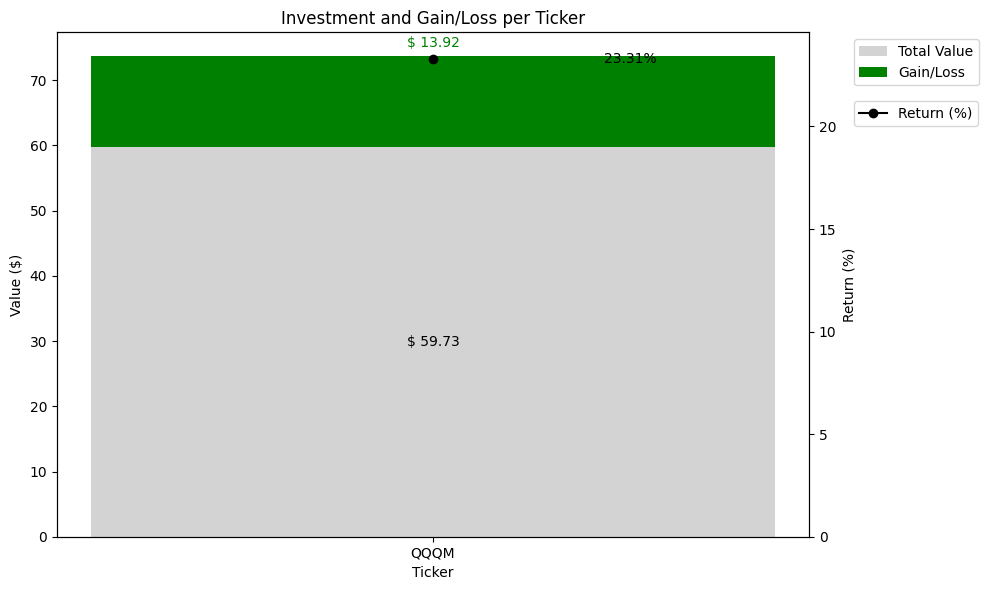

In [19]:
if __name__ == "__main__":
    application()

---